# Jira Comments – LLM-Assisted Thematic Analysis

1. **Load and clean** Jira comments exported from your PowerShell script.  
2. **Normalize** multiple comments per SWIFT (issue key) while keeping the link between each comment and its issue.  
3. **De-identify** and prepare the comment text for upload to an LLM (e.g. Copilot / GPT) for theme discovery and labeling.  
4. (Optional) **Join back** LLM-generated labels with the comments for further analysis and visualization.


## 1. Setup & Imports

In [ ]:
# Cell 1 – Imports and basic config

import os
import re
import json
import pandas as pd
import numpy as np

pd.set_option("display.max_colwidth", 200)

# OpenAI import for automated theme analysis
from openai import OpenAI

def analyze_themes_automated(comments_df, num_themes=10):
    """Automated theme discovery using LLM API"""
    client = OpenAI(api_key=os.environ.get("OPENAI_API_KEY"))
    
    # Prepare prompt
    prompt = f"""Analyze these Jira comments about project delays.
    
{comments_df['text_clean'].to_string()}

Identify {num_themes} high-level themes. Return JSON:
{{
  "themes": [
    {{
      "theme": "Theme name",
      "description": "One sentence description",
      "examples": ["phrase 1", "phrase 2", "phrase 3"]
    }}
  ]
}}"""
    
    response = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[{"role": "user", "content": prompt}],
        response_format={"type": "json_object"}
    )
    
    return json.loads(response.choices[0].message.content)

## 2. Load the Jira comments CSV

Update the `csv_path` below to point to your exported `JiraComments_FromJql.csv` (or similar).

In [4]:
# Cell 2 – Load CSV

csv_path = r"C:\Users\Andy\Desktop\Text_Analysis\JiraComments_FromJql.csv"  # <-- change this to your actual path

if not os.path.exists(csv_path):
    raise FileNotFoundError(f"CSV not found at: {csv_path}\nPlease update csv_path to the correct location.")

df = pd.read_csv(csv_path)

print("Rows:", len(df))
print("Columns:", list(df.columns))
df.head(30)

Rows: 241
Columns: ['IssueKey', 'CommentId', 'Author', 'AuthorEmail', 'Created', 'Updated', 'Body']


,IssueKey,CommentId,Author,AuthorEmail,Created,Updated,Body
0,SWIFT-7544,55859,Molly Andrasik,molly.andrasik@rochesterregional.org,2025-10-28T11:26:52.037-0400,2025-10-28T11:26:52.037-0400,This was not ready for PRD by 10/27. Dr. Mullin is targeting 11/6. Adding the November release.
1,SWIFT-7544,56452,Molly Andrasik,molly.andrasik@rochesterregional.org,2025-11-04T12:32:55.637-0500,2025-11-04T12:32:55.637-0500,[~SMULLIN] and [~T324172] - We were targeting this for 11/6. Is that still the plan?
2,SWIFT-7544,56508,"Mullin, Suzanne",Suzanne.Mullin@rochesterregional.org,2025-11-04T13:19:01.640-0500,2025-11-04T13:19:01.640-0500,Yes. Working on it now\r\n\r\n
3,SWIFT-7544,56584,Molly Andrasik,molly.andrasik@rochesterregional.org,2025-11-05T11:50:14.713-0500,2025-11-05T11:50:14.713-0500,CRQ7023685 planned for Maintenance release on 11/6.
4,SWIFT-7543,55787,Molly Andrasik,molly.andrasik@rochesterregional.org,2025-10-28T10:22:16.687-0400,2025-10-28T10:22:16.687-0400,[~SMULLIN] and [~LYOGIS] was this completed last week? Has it been moved to PRD?
5,SWIFT-7543,55792,"Mullin, Suzanne",Suzanne.Mullin@rochesterregional.org,2025-10-28T10:25:51.763-0400,2025-10-28T10:25:51.763-0400,[~m328246] working on today. Anticipating a 10/30 go live\r\n\r\n
6,SWIFT-7543,55861,Molly Andrasik,molly.andrasik@rochesterregional.org,2025-10-28T11:27:44.930-0400,2025-10-28T11:27:44.930-0400,"Adding the November release, as this didn't make it to PRD by 10/27."
7,SWIFT-7492,55249,"Keller, Julia",Julia.Keller@rochesterregional.org,2025-10-23T16:23:18.873-0400,2025-10-23T16:23:18.873-0400,mg/kg unit added to ERX 200145
8,SWIFT-7492,55199,Molly Andrasik,molly.andrasik@rochesterregional.org,2025-10-23T17:42:31.917-0400,2025-10-23T17:42:31.917-0400,Updated to the November release because the CRQ was not submitted in time for 10/27.
9,SWIFT-7492,56021,Lauren Yogis,lauren.yogis@rochesterregional.org,2025-10-29T10:36:23.053-0400,2025-10-29T10:36:23.053-0400,[~M314010] the Willow build for this is complete. Let us know when you are ready for testing.


## 3. Normalize structure: one row = one comment

Here we:

- Identify the likely **issue key column** (e.g. `IssueKey`).  
- Identify the **comment body column** (e.g. `Body`).  
- Keep those plus any IDs that help us track comments later (e.g. `CommentId`).  
- Ensure that each row is a single comment with its associated SWIFT / Jira issue key.


In [5]:
# Cell 3 – Normalize and select key columns

possible_issue_cols = ["IssueKey", "issueKey", "Key", "key"]
possible_body_cols  = ["Body", "body", "Comment", "comment", "Text", "text"]
possible_id_cols    = ["CommentId", "commentId", "Id", "id"]
possible_time_cols  = ["Created", "created", "Timestamp", "timestamp", "Updated", "updated"]

issue_col = next((c for c in possible_issue_cols if c in df.columns), None)
body_col  = next((c for c in possible_body_cols  if c in df.columns), None)
id_col    = next((c for c in possible_id_cols    if c in df.columns), None)
time_col  = next((c for c in possible_time_cols  if c in df.columns), None)

if issue_col is None or body_col is None:
    raise ValueError(
        f"Could not find issue or body column.\n"
        f"Available columns: {list(df.columns)}\n"
        f"Expected something like {possible_issue_cols} and {possible_body_cols}"
    )

print(f"Using issue column : {issue_col}")
print(f"Using body column  : {body_col}")
print(f"Using ID column    : {id_col if id_col else '(none – will create one)'}")
print(f"Using time column  : {time_col if time_col else '(none found)'}")

# Build a normalized DataFrame
cols_to_keep = [issue_col, body_col]
if id_col:
    cols_to_keep.append(id_col)
if time_col:
    cols_to_keep.append(time_col)

data = df[cols_to_keep].copy()
data.rename(columns={issue_col: "IssueKey", body_col: "Body"}, inplace=True)
if time_col:
    data.rename(columns={time_col: "Timestamp"}, inplace=True)

# Create a synthetic comment_id if none exists
if id_col is None:
    data.insert(0, "CommentSeq", np.arange(1, len(data) + 1))
else:
    data.rename(columns={id_col: "CommentId"}, inplace=True)
    if "CommentId" not in data.columns:
        data.insert(0, "CommentSeq", np.arange(1, len(data) + 1))

# Ensure Body is string and non-empty
data["Body"] = data["Body"].astype(str).str.strip()
data = data[data["Body"].str.len() > 0].reset_index(drop=True)

# If we have a timestamp, parse and sort by IssueKey + Timestamp
if "Timestamp" in data.columns:
    data["Timestamp"] = pd.to_datetime(data["Timestamp"], errors="coerce")
    data = data.sort_values(["IssueKey", "Timestamp"], ascending=[True, True])
    data = data.reset_index(drop=True)

print("\nAfter normalization:")
print("Rows (comments):", len(data))
print("Distinct SWIFT / issue keys:", data["IssueKey"].nunique())

data.head(10)

Using issue column : IssueKey
Using body column  : Body
Using ID column    : CommentId
Using time column  : Created

After normalization:
Rows (comments): 241
Distinct SWIFT / issue keys: 39


C:\Users\Andy\AppData\Local\Temp\ipykernel_39484\3434946217.py:51: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  data["Timestamp"] = pd.to_datetime(data["Timestamp"], errors="coerce")


,IssueKey,Body,CommentId,Timestamp
0,SWIFT-5662,[Create and Configure a Telemedicine Visit Type|https://galaxy.epic.com/Redirect.aspx?DocumentID=100130082&PrefDocID=98346]\r\nh3. Create and Configure a Telemedicine Visit Type\r\n\r\nTo schedule...,51442,2025-09-25 12:34:02.470000-04:00
1,SWIFT-5662,Will require design help from Cadence and HI.,51768,2025-09-30 17:51:30.803000-04:00
2,SWIFT-5662,"Shannon Gaurin, Jessica Canton, Mary King, Jamie Conrow, and Pearlie Petty met to discuss design requirements, all in agreement this is specifically a reporting request.\r\n * Shannon met with Tin...",51977,2025-10-03 14:34:36.247000-04:00
3,SWIFT-5662,Requestor (Janene) Is ok with waiting for the visit mode update to go live for this change,52458,2025-10-08 08:31:44.120000-04:00
4,SWIFT-5662,Transferring Design ownership to DA - Tina Grann. No build required from listed teams. Additional teams can close out their Issues after documenting their time. Recommend keeping HI and AMB Iss...,52459,2025-10-08 08:43:42.157000-04:00
5,SWIFT-5662,"[~tgrann], [~t275735], [~MKING2], [~S329782] where did we land with the Design for this? Are those discussions complete? Please provide an update.",54559,2025-10-20 09:14:35.607000-04:00
6,SWIFT-5662,"[~tgrann], [~t275735], [~MKING2], [~S329782] [~g303497] : talked to tracy this morning : Current status is that Garrett and Tracy are going to reach out to Janene to determing if we can come up ...",54586,2025-10-20 11:02:35.083000-04:00
7,SWIFT-5662,[~m328246] - Please see update below. Our meeting is scheduled for 10/27 with Janene which will make it difficult to complete design during this release.,54700,2025-10-20 11:13:18.757000-04:00
8,SWIFT-5662,"Pushing this to the mid-November release, per Garret's update that they are meeting with Operations on 10/27.",54913,2025-10-21 11:37:49.880000-04:00
9,SWIFT-6337,"[~JRUBIN] is this design in progress? Based on the status it is being worked on, but I don't see any updates. It is not currently assigned to the October release, so wanted to see where we are, an...",52430,2025-10-07 13:50:39.060000-04:00


## 4. De-identification & text cleaning

We will:

- Remove Jira user mentions like `[~USER]`.  
- Remove obvious CRQ numbers (`CRQ1234567`).  
- Remove email addresses.  
- Optionally remove issue keys themselves from the comment text.  
- Keep a clean text column suitable for sending to an LLM.

We **do not** touch the `IssueKey` column itself so we can always trace a comment back to its SWIFT later.


In [6]:
# Cell 4 – De-identification and cleaning

mention_pattern    = re.compile(r"\[~[^\]]+\]")         # [~username]
crq_pattern        = re.compile(r"CRQ\d+", re.IGNORECASE)
email_pattern      = re.compile(r"[\w\.\-]+@[\w\.-]+")
whitespace_pattern = re.compile(r"\s+")

def clean_and_deidentify(row):
    text = str(row["Body"])

    # Remove Jira mentions like [~SMULLIN]
    text = mention_pattern.sub(" ", text)

    # Remove CRQ-style change request numbers
    text = crq_pattern.sub(" ", text)

    # Remove email addresses
    text = email_pattern.sub(" ", text)

    # Remove the explicit issue key text if it appears inside the body
    issue_key = str(row["IssueKey"])
    if issue_key and issue_key in text:
        text = text.replace(issue_key, " ")

    # Remove extra non-informative characters
    # (Keep basic punctuation; strip control chars)
    text = re.sub(r"[^a-zA-Z0-9\s,.!?'-]", " ", text)

    # Normalize whitespace and lowercase
    text = whitespace_pattern.sub(" ", text).strip().lower()

    return text

data["text_clean"] = data.apply(clean_and_deidentify, axis=1)

data[["IssueKey", "Body", "text_clean"]].head(10)

,IssueKey,Body,text_clean
0,SWIFT-5662,[Create and Configure a Telemedicine Visit Type|https://galaxy.epic.com/Redirect.aspx?DocumentID=100130082&PrefDocID=98346]\r\nh3. Create and Configure a Telemedicine Visit Type\r\n\r\nTo schedule...,"create and configure a telemedicine visit type https galaxy.epic.com redirect.aspx?documentid 100130082 prefdocid 98346 h3. create and configure a telemedicine visit type to schedule video visits,..."
1,SWIFT-5662,Will require design help from Cadence and HI.,will require design help from cadence and hi.
2,SWIFT-5662,"Shannon Gaurin, Jessica Canton, Mary King, Jamie Conrow, and Pearlie Petty met to discuss design requirements, all in agreement this is specifically a reporting request.\r\n * Shannon met with Tin...","shannon gaurin, jessica canton, mary king, jamie conrow, and pearlie petty met to discuss design requirements, all in agreement this is specifically a reporting request. shannon met with tina to d..."
3,SWIFT-5662,Requestor (Janene) Is ok with waiting for the visit mode update to go live for this change,requestor janene is ok with waiting for the visit mode update to go live for this change
4,SWIFT-5662,Transferring Design ownership to DA - Tina Grann. No build required from listed teams. Additional teams can close out their Issues after documenting their time. Recommend keeping HI and AMB Iss...,transferring design ownership to da - tina grann. no build required from listed teams. additional teams can close out their issues after documenting their time. recommend keeping hi and amb issues...
5,SWIFT-5662,"[~tgrann], [~t275735], [~MKING2], [~S329782] where did we land with the Design for this? Are those discussions complete? Please provide an update.",", , , where did we land with the design for this? are those discussions complete? please provide an update."
6,SWIFT-5662,"[~tgrann], [~t275735], [~MKING2], [~S329782] [~g303497] : talked to tracy this morning : Current status is that Garrett and Tracy are going to reach out to Janene to determing if we can come up ...",", , , talked to tracy this morning current status is that garrett and tracy are going to reach out to janene to determing if we can come up with a brd that better documents her need and keep her f..."
7,SWIFT-5662,[~m328246] - Please see update below. Our meeting is scheduled for 10/27 with Janene which will make it difficult to complete design during this release.,- please see update below. our meeting is scheduled for 10 27 with janene which will make it difficult to complete design during this release.
8,SWIFT-5662,"Pushing this to the mid-November release, per Garret's update that they are meeting with Operations on 10/27.","pushing this to the mid-november release, per garret's update that they are meeting with operations on 10 27."
9,SWIFT-6337,"[~JRUBIN] is this design in progress? Based on the status it is being worked on, but I don't see any updates. It is not currently assigned to the October release, so wanted to see where we are, an...","is this design in progress? based on the status it is being worked on, but i don't see any updates. it is not currently assigned to the october release, so wanted to see where we are, and if it sh..."


### Quick sanity check

Let’s look at a few random comments to ensure:

- They are de-identified.  
- They still make sense semantically (so an LLM can interpret them).

In [7]:
# Cell 5 – Random sample for manual inspection

data.sample(min(10, len(data)), random_state=42)[["IssueKey", "text_clean"]]

,IssueKey,text_clean
24,SWIFT-6889,", - i will move this to the november release. however, please use this as a lesson learned moving forward. design conversations should be front-loaded in the release cycle so this doesn't happen a..."
6,SWIFT-5662,", , , talked to tracy this morning current status is that garrett and tracy are going to reach out to janene to determing if we can come up with a brd that better documents her need and keep her f..."
222,SWIFT-7393,"completed, sd extract provided to requestor in a password protected excel file"
208,SWIFT-7300,"per mostafa, this is not ready for prd after testing last week. moving this back to in progress. anticipated completion for the 10 27 release."
236,SWIFT-7543,"adding the november release, as this didn't make it to prd by 10 27."
173,SWIFT-7084,"reached out via teams for a status update , , - 5012875 primary care follow-up order and ticket scheduling. the design epic is to do , but the stories are done or in progress. please update the de..."
197,SWIFT-7287,changes are in ssrs report with new columns added along with new parameter choice. the report runs and output produced. i have a meeting with dr. higgins 10 22 for final review to be set for dev b...
220,SWIFT-7393,"i had updated the fix version release , but forgot to update the end date on the epic and idea. that has been done now. is there something else you are seeing that is incorrect?"
9,SWIFT-6337,"is this design in progress? based on the status it is being worked on, but i don't see any updates. it is not currently assigned to the october release, so wanted to see where we are, and if it sh..."
113,SWIFT-7042,"checking in on this one, as it is assigned to the 10 27 release for dev but there are no updates on progress, and it is assigned to you rather than an analyst. thanks!"


In [ ]:
# Set your OpenAI API key (REPLACE WITH YOUR ACTUAL KEY!)
os.environ["OPENAI_API_KEY"] = "sk-proj-YOUR-NEW-KEY-HERE"

# Run automated theme discovery
print("🤖 Starting automated theme analysis...")
print(f"📊 Analyzing {len(data)} comments from {data['IssueKey'].nunique()} issues...\n")

themes_result = analyze_themes_automated(data, num_themes=10)

# Display results
print("\n" + "="*80)
print("DISCOVERED THEMES")
print("="*80)
for i, theme in enumerate(themes_result["themes"], 1):
    print(f"\n{i}. {theme['theme']}")
    print(f"   {theme['description']}")
    print(f"   Examples: {', '.join(theme['examples'][:2])}")
    
print(f"\n✅ Theme discovery complete!")

## 7. Automated Theme Discovery with OpenAI

Now we'll use the OpenAI API to automatically discover themes instead of manual copying.

## 5. Prepare text for LLM theme discovery

Now we’ll format the comments into a prompt-friendly structure you can paste into Copilot / GPT.

For example, we’ll generate something like:

```text
1. [Issue SWIFT-7544] this was not ready for prd by 10/27 ...
2. [Issue SWIFT-7543] adding the november release ...
...
```

You can then paste that list into your LLM with the prompt:

> “Here are Jira comments about why work wasn’t completed in October.  
> Read all of them and propose 5–10 high-level themes, each with:  
> • A short title  
> • A one-sentence description of the reason for delay  
> • A few example phrases that fit that theme.  
> Return JSON with keys: `theme`, `description`, `examples`.”


In [8]:
# Cell 6 – Build grouped, ordered comments for LLM input

rows_for_llm = []

# We'll group by IssueKey, and within each group the rows are already sorted by Timestamp
for issue, grp in data.groupby("IssueKey", sort=True):
    rows_for_llm.append(f"Issue {issue}:")
    for _, row in grp.iterrows():
        ts = row["Timestamp"] if "Timestamp" in row and pd.notna(row["Timestamp"]) else None
        txt = row["text_clean"]

        if ts is not None:
            ts_str = ts.strftime("%Y-%m-%d %H:%M")
            rows_for_llm.append(f"  - [{ts_str}] {txt}")
        else:
            rows_for_llm.append(f"  - {txt}")
    rows_for_llm.append("")  # blank line between issues

llm_input_block = "\n".join(rows_for_llm)

print(llm_input_block)  # show the first ~4000 characters


Issue SWIFT-5662:
  - [2025-09-25 12:34] create and configure a telemedicine visit type https galaxy.epic.com redirect.aspx?documentid 100130082 prefdocid 98346 h3. create and configure a telemedicine visit type to schedule video visits, you need to create a visit type. epic recommends that you create unified visit types using telehealth mode flags rather than creating separate video visit types for existing visit types in your system. if you've already created visit types for which you need a video visit type, you can reuse the existing visit type if its configuration can generally apply to video visits as well. refer to the set available telehealth modes for visit types https galaxy.epic.com redirect.aspx?documentid 100076772 topic for more information about using the telehealth mode flag with new or existing visit types.
  - [2025-09-30 17:51] will require design help from cadence and hi.
  - [2025-10-03 14:34] shannon gaurin, jessica canton, mary king, jamie conrow, and pearlie pet

# Prompt

1. Copy the printed `llm_input_block` text above (the numbered list of comments).  
2. Paste it into your LLM with a prompt like:

> “Here are Jira comments about why work wasn’t completed in October.  
> Read all of them and propose 5–10 high-level themes, each with:  
> • A short title  
> • A one-sentence description of the reason for delay  
> • A few example phrases that fit that theme.  
> Return JSON with keys: `theme`, `description`, `examples`.”

3. Review and possibly edit the returned themes and descriptions.  
4. Decide on your final theme list (e.g. in a separate document or directly in the next cell).


## 6. (Optional) Assign themes back to each comment

After the LLM proposes themes and you finalize them, you can also ask the LLM to **assign a theme to each comment**.

### Example prompt for assignment

For each comment (or for small batches), you might say:

> “Here is a Jira comment about why work wasn’t completed:  
> `<comment text>`  
>  
> Based on the following themes:  
> 1. CRQ timing / missed release window  
> 2. Waiting on other team / vendor  
> 3. Approvals / leadership not finalized  
> 4. Requirements unclear / design not complete  
> 5. Testing / QA / UAT delays  
> 6. Capacity / competing priorities  
> 7. Other / unclear  
>  
> Return only the number and name of the single best-fitting theme.”

You can copy the numbered list of comments and ask the LLM to return a simple table or JSON mapping `comment_number -> theme`.


In [ ]:
import pandas as pd, json

with open("C:/Users/Andy/Desktop/Text_Analysis/JSON_themes.json", "r") as f:
    json_data = json.load(f)  # Changed from 'data' to 'json_data'

themes = pd.DataFrame(json_data["themes"])
issues = pd.DataFrame(json_data["issues"])

summary = {
    "Total Issues": len(issues),
    "Total Themes": len(themes),
    "Avg Themes per Issue": issues["themes"].apply(len).mean()
}
pd.DataFrame([summary])

In [ ]:
import json
import os
from collections import Counter
import itertools

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

json_path = r"C:\Users\Andy\Desktop\Text_Analysis\JSON_themes.json"

with open(json_path, "r", encoding="utf-8") as f:
    json_data = json.load(f)  # Changed from 'data' to 'json_data'

# Adjust these keys if your JSON is shaped differently
themes_raw = json_data.get("themes", [])
issues_raw = json_data.get("issues", [])

themes_df = pd.DataFrame(themes_raw)
issues_df = pd.DataFrame(issues_raw)

print("Themes:", themes_df.shape)
print("Issues:", issues_df.shape)
themes_df.head(), issues_df.head()

In [13]:
# Count how many issues each theme appears in
all_theme_mentions = [t for theme_list in issues_df["themes"] for t in theme_list]
theme_counts = Counter(all_theme_mentions)

theme_freq = (
    pd.DataFrame(theme_counts.items(), columns=["Theme", "Count"])
    .sort_values("Count", ascending=False)
)

theme_freq


,Theme,Count
4,Scope Changes or Updated Requirements,8
1,Operational Sign-Off Delays,7
2,Scheduling and Coordination Issues,7
0,Dependency on Other Teams or Resources,5
7,Operational Readiness Gaps,4
6,Technical Complexity or Unknowns,3
9,Resource Availability Constraints,2
3,Late or Incomplete Design Phase,1
5,Risk Not Communicated Early,1
8,External Vendor or Third-Party Dependency,1


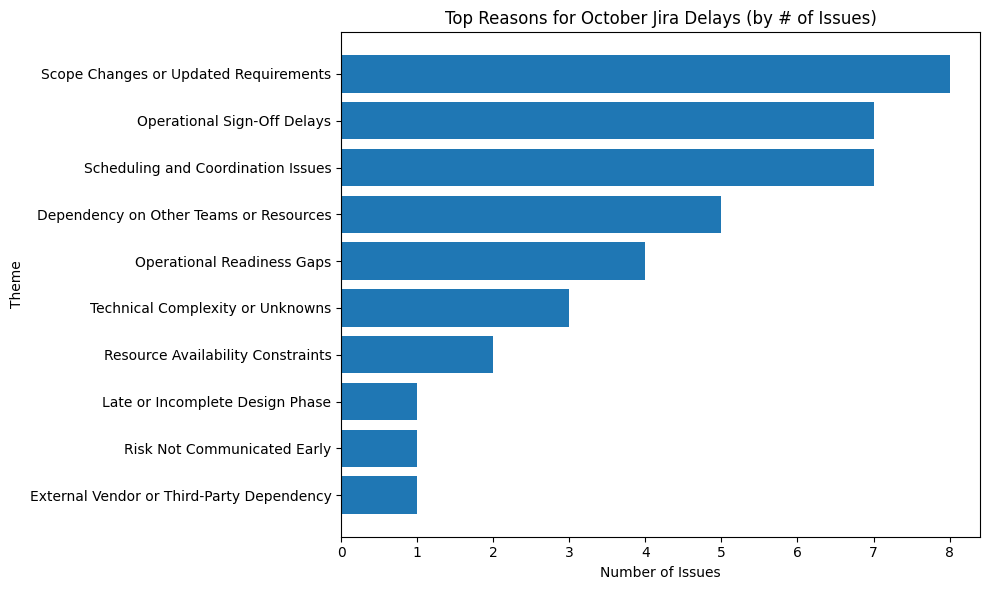

In [14]:
# Bar chart
plt.figure(figsize=(10, 6))

plt.barh(theme_freq["Theme"], theme_freq["Count"])
plt.gca().invert_yaxis()  # largest at top

plt.title("Top Reasons for October Jira Delays (by # of Issues)")
plt.xlabel("Number of Issues")
plt.ylabel("Theme")

plt.tight_layout()
plt.show()
